In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from keras.utils import np_utils
from tqdm import tqdm_notebook as tqdm
from time import time, sleep

/home/parubchenko/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
melodies = []
with open('my_data/notes', 'rb') as filepath:
    melodies = pickle.load(filepath)

In [4]:
labels = []
with open('my_data/labels', 'rb') as filepath:
    labels = pickle.load(filepath)

In [6]:
ex_melodies = []
with open('my_data/extended_notes', 'rb') as filepath:
    ex_melodies = pickle.load(filepath)

In [7]:
notes = []

for melody in tqdm(melodies):
    key = melody[0]
    if key in labels:
        notes.append('Start')
        for note in melody[1]:
            if '.' not in note or len(note.split('.')) <= 3:
                notes.append(note)
        notes.append('End')

In [32]:
notes = []

for melody in tqdm(ex_melodies):
    key = melody[0]
    if key in labels:
        notes.append('Start')
        for note in melody[1]:
            q = note.split(':')[0]
            try:
                offset = float(note.split(':')[1])
                if offset in [0.25, 0.5, 1, 1.5] and ('.' not in q or len(q.split('.')) <= 3):
                    notes.append(note)
            except ValueError:
                pass
        notes.append('End')

In [33]:
# Get all pitch names
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))
n_emots = len(set(val for val in labels.values()))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
# create a reversed dictionary to map integers to pitches
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

In [47]:
sequence_length = 32
network_input = []
emotion_input = []

for melody in tqdm(ex_melodies):#(melodies):
    key = melody[0]
    if key in labels:
        emotion = labels[key]
        melody_notes = ['Start'] 
        for note in melody[1]:
            q = note.split(':')[0]
            try:
                offset = float(note.split(':')[1])
                if offset in [0.25, 0.5, 1, 1.5] and ('.' not in q or len(q.split('.')) <= 3):
                    melody_notes.append(note)
            except ValueError:
                pass
            #if '.' not in note or len(note.split('.')) <= 3:
            #    melody_notes.append(note)
        melody_notes += ['End']

        for i in range(0, len(melody_notes) - sequence_length, 1):
            sequence_in = melody_notes[i:i + sequence_length]
            network_input.append([note_to_int[char] for char in sequence_in])
            emotion_input.append(emotion)

### Emotion Classificator 

In [48]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [49]:
class NotTuple(nn.Module):
    def forward(self, input):
        return input[0]

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [50]:
emb_size = 32
model = nn.Sequential(
    nn.Embedding(n_vocab, emb_size),
    nn.LSTM(input_size=emb_size, hidden_size=64, 
            num_layers=3, batch_first=True, dropout=0.3),
    NotTuple(),
    nn.Tanh(),
    Flatten(),
    nn.Linear(1984, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 3),
).cuda()

In [51]:
Songs = np.array(network_input)[:, :-1]
Emotions = np.array(emotion_input)

In [53]:
length = Songs.shape[0]
indices = np.random.choice(length, int(0.2*length), replace=False)

In [54]:
with open('my_data/indices2', 'wb') as filepath:
    pickle.dump(indices, filepath)

In [55]:
from sklearn.model_selection import train_test_split

Song_train, Song_val, Emotion_train, Emotion_val = train_test_split(
    Songs[indices], Emotions[indices], test_size=0.1, shuffle=True)

In [58]:
def iterate_batches(fragments, emotions, batch_size):
    #permute indicies
    indices = np.random.permutation(np.arange(len(fragments)))
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        #get emotions
        batch_emotions = emotions[ix]
        #get songs fragments
        batch_fragments = fragments[ix]
        
        yield Variable(torch.LongTensor(batch_fragments)).cuda(), torch.LongTensor(batch_emotions).cuda()

In [59]:
batch_size = 32
n_epochs = 50

In [60]:
criterion = nn.CrossEntropyLoss().cuda()

In [61]:
network = model
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

val_minumum = np.inf
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs), desc='Epochs'):
    start = time()
    train_loss=0
    
    network.train(True)
    batches = 0
    for fragment_batch, emotion_batch in tqdm(
        iterate_batches(Song_train, Emotion_train, batch_size), leave=False, desc='Train'):
        batches += 1
        output = model.forward(fragment_batch)
        loss_t = criterion(output, emotion_batch)
        show = True if batches == 1 else False
        if show:
            print('Diffs:', (torch.sum(torch.argmax(output, dim=1) != 
                                       emotion_batch.view(-1)).data.cpu().numpy()))

        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.data.cpu().numpy()
        
    train_loss /= batches
    train_losses.append(train_loss)
    
    val_loss=0
    
    network.train(False)
    batches = 0
    for fragment_batch, emotion_batch in iterate_batches(Song_val, Emotion_val, batch_size):
        batches += 1
        output = model.forward(fragment_batch)
        loss_t = criterion(output, emotion_batch)
        
        val_loss += loss_t.data.cpu().numpy()
    val_loss /= batches
    val_losses.append(val_loss)
    
    is_best = val_loss < val_minumum
    if is_best:
        val_minumum = val_loss
        torch.save(network.state_dict(), 'Classificator2.pth')
    
    print("""Epoch: {}/{}
{:.0f}s - train_loss: {:.3f} - val loss: {:.3f}""".format(
        epoch+1, n_epochs, time() - start, train_loss, val_loss))

print("Finished!")

Diffs: 21
Epoch: 1/50
10s - train_loss: 0.597 - val loss: 0.383


Diffs: 3
Epoch: 2/50
10s - train_loss: 0.302 - val loss: 0.204


Diffs: 3
Epoch: 3/50
11s - train_loss: 0.181 - val loss: 0.149


Diffs: 3
Epoch: 4/50
9s - train_loss: 0.137 - val loss: 0.110


Diffs: 1
Epoch: 5/50
9s - train_loss: 0.094 - val loss: 0.089


Diffs: 2
Epoch: 6/50
10s - train_loss: 0.083 - val loss: 0.095


Diffs: 0
Epoch: 7/50
10s - train_loss: 0.075 - val loss: 0.090


Diffs: 0
Epoch: 8/50
10s - train_loss: 0.062 - val loss: 0.072


Diffs: 0
Epoch: 9/50
10s - train_loss: 0.057 - val loss: 0.089


Diffs: 0
Epoch: 10/50
9s - train_loss: 0.049 - val loss: 0.084


Diffs: 1
Epoch: 11/50
10s - train_loss: 0.047 - val loss: 0.083


Diffs: 0
Epoch: 12/50
10s - train_loss: 0.047 - val loss: 0.061


Diffs: 1
Epoch: 13/50
10s - train_loss: 0.048 - val loss: 0.068


Diffs: 0
Epoch: 14/50
10s - train_loss: 0.042 - val loss: 0.056


Diffs: 1
Epoch: 15/50
10s - train_loss: 0.041 - val loss: 0.067


Diffs: 0
Epoch: 16/50
9s - train_loss: 0.038 - val loss: 0.048


Diffs: 1
Epoch: 17/50
9s - train_loss: 0.038 - val loss: 0.052


Diffs: 0
Epoch: 18/50
10s - train_loss: 0.033 - val loss: 0.062


Diffs: 0
Epoch: 19/50
10s - train_loss: 0.035 - val loss: 0.059


Diffs: 1
Epoch: 20/50
10s - train_loss: 0.033 - val loss: 0.083


Diffs: 0
Epoch: 21/50
10s - train_loss: 0.032 - val loss: 0.071


Diffs: 0
Epoch: 22/50
9s - train_loss: 0.032 - val loss: 0.042


Diffs: 0
Epoch: 23/50
9s - train_loss: 0.032 - val loss: 0.044


Diffs: 0
Epoch: 24/50
10s - train_loss: 0.032 - val loss: 0.055


Diffs: 1
Epoch: 25/50
10s - train_loss: 0.028 - val loss: 0.060


Diffs: 0
Epoch: 26/50
10s - train_loss: 0.027 - val loss: 0.061


Diffs: 1
Epoch: 27/50
10s - train_loss: 0.033 - val loss: 0.064


Diffs: 0
Epoch: 28/50
10s - train_loss: 0.026 - val loss: 0.061


Diffs: 0
Epoch: 29/50
10s - train_loss: 0.029 - val loss: 0.067


Diffs: 0
Epoch: 30/50
10s - train_loss: 0.026 - val loss: 0.055


Diffs: 0
Epoch: 31/50
10s - train_loss: 0.024 - val loss: 0.061


Diffs: 0
Epoch: 32/50
10s - train_loss: 0.025 - val loss: 0.043


Diffs: 0
Epoch: 33/50
10s - train_loss: 0.026 - val loss: 0.062


Diffs: 0
Epoch: 34/50
9s - train_loss: 0.024 - val loss: 0.051


Diffs: 0
Epoch: 35/50
10s - train_loss: 0.026 - val loss: 0.060


Diffs: 0
Epoch: 36/50
10s - train_loss: 0.020 - val loss: 0.061


Diffs: 0
Epoch: 37/50
10s - train_loss: 0.023 - val loss: 0.061


Diffs: 0
Epoch: 38/50
10s - train_loss: 0.023 - val loss: 0.050


Diffs: 0
Epoch: 39/50
9s - train_loss: 0.021 - val loss: 0.064


Diffs: 0
Epoch: 40/50
9s - train_loss: 0.022 - val loss: 0.067


Diffs: 0
Epoch: 41/50
10s - train_loss: 0.022 - val loss: 0.055


Diffs: 0
Epoch: 42/50
10s - train_loss: 0.018 - val loss: 0.067


Diffs: 0
Epoch: 43/50
10s - train_loss: 0.023 - val loss: 0.065


Diffs: 1
Epoch: 44/50
10s - train_loss: 0.019 - val loss: 0.072


Diffs: 0
Epoch: 45/50
10s - train_loss: 0.020 - val loss: 0.054


Diffs: 0
Epoch: 46/50
9s - train_loss: 0.020 - val loss: 0.060


Diffs: 1
Epoch: 47/50
9s - train_loss: 0.020 - val loss: 0.078


Diffs: 0
Epoch: 48/50
9s - train_loss: 0.016 - val loss: 0.084


Diffs: 0
Epoch: 49/50
10s - train_loss: 0.020 - val loss: 0.070


Diffs: 0
Epoch: 50/50
10s - train_loss: 0.018 - val loss: 0.062

Finished!


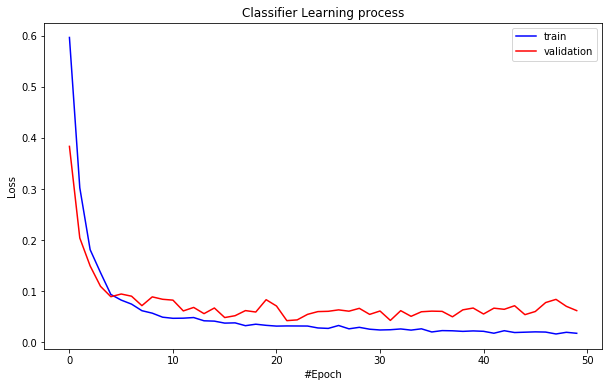

In [62]:
fig, ax = plt.subplots(1, figsize=(10, 6))

ax.plot(train_losses, c='b', label='train')
ax.plot(val_losses, c='r', label='validation')
ax.set_ylabel('Loss')
ax.set_xlabel('#Epoch')
ax.set_title('Classifier Learning process')
ax.legend()
fig.savefig('clp2.png')

In [226]:
(Songs.shape[0] - indices.shape[0]) * 0.1

22030.0